# Машинное обучение и майнинг данных
## 09/02/2017 Деревья решений, подбор параметров с помощью кросс-валидации

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

# Регрессия

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

Рассмотрим данные по характеристикам автомобилей Honda Accord. Названия столбцов говорят сами за себя ([обучение](http://bit.ly/1gIQs6C), [тест](http://bit.ly/IYPHrK)). 


In [3]:
df_train = pd.read_csv('http://bit.ly/1gIQs6C')
df_test = pd.read_csv('http://bit.ly/IYPHrK')
df_train.head()

,price,mileage,year,trim,engine,transmission
0,14995,67697,2006,ex,4 Cyl,Manual
1,11988,73738,2006,ex,4 Cyl,Manual
2,11999,80313,2006,lx,4 Cyl,Automatic
3,12995,86096,2006,lx,4 Cyl,Automatic
4,11333,79607,2006,lx,4 Cyl,Automatic


Постараемся сделать следующее:
* Мы подготовим процедуры автоматической обработки таблиц
* С помощью кросс-валидации определим хорошие гиперпараметры для модели

Метрика качества **среднее абсолютное** отклонение

## Подготовим процедуры

Необходимо убрать ненужные переменные, перевести все в формат, подходящий для дерева.

Помочь может метод `df.pipe(function)`.

In [4]:
df_train.year.unique()

# Можно выбросить

array([2006])

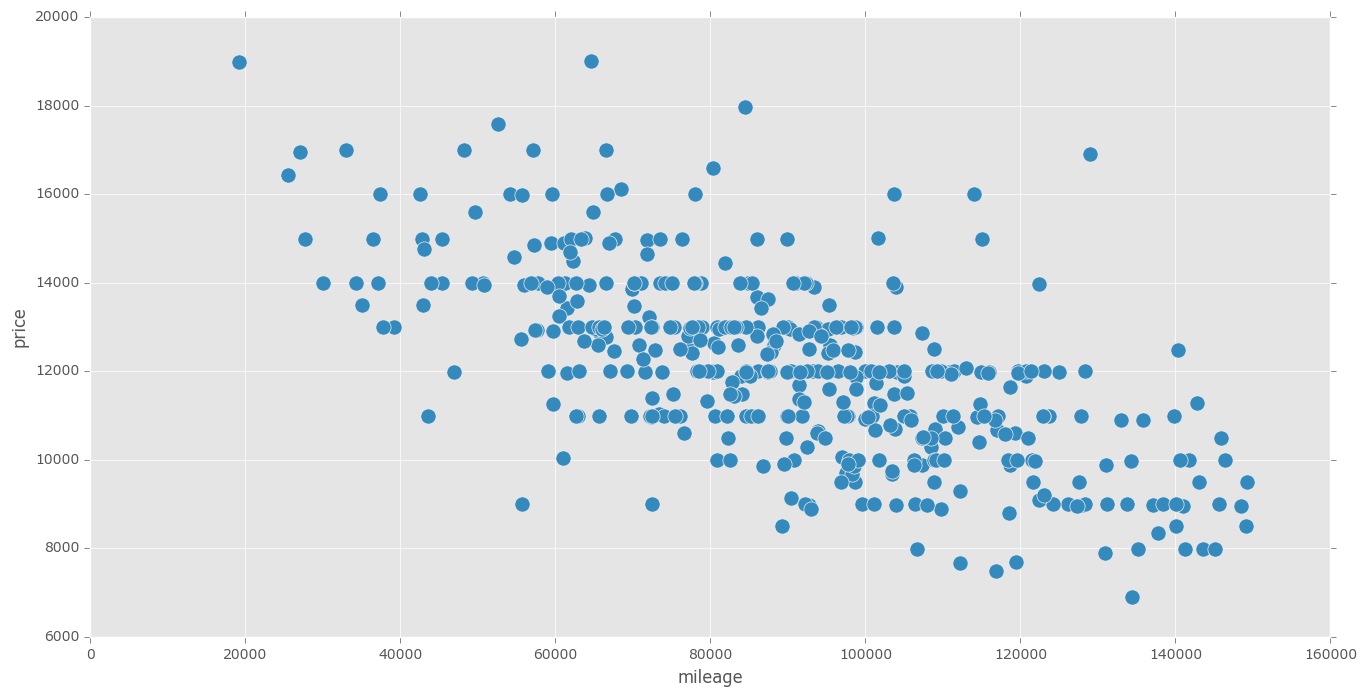

In [5]:
df_train.plot(y='price', x='mileage', kind='scatter', s=120)

In [6]:

df_train.head()

,price,mileage,year,trim,engine,transmission
0,14995,67697,2006,ex,4 Cyl,Manual
1,11988,73738,2006,ex,4 Cyl,Manual
2,11999,80313,2006,lx,4 Cyl,Automatic
3,12995,86096,2006,lx,4 Cyl,Automatic
4,11333,79607,2006,lx,4 Cyl,Automatic


In [7]:
def preprocess_dataframe(df_input):

    df = df_input.copy()

    # Выкинуть year
    df = df.drop('year', axis=1)

    # Преобразовать trim и engine,и transmission в нужный формат
    df = df.join(pd.get_dummies(df.loc[:, 'trim'], prefix='trim'))
    df = df.drop('trim', axis=1)

    df.loc[:, 'transmission'] = df.loc[:, 'transmission'].replace({'Manual': 1,
                                                                   'Automatic': 0})
    
    # Для дерева решений все одинаково
    df.loc[:, 'engine'] = df.loc[:, 'engine'].str.split(' ')\
                                             .str.get(0)\
                                             .astype(int)
            
    return df

# Запускаем pipe
df_train_preproc = df_train.pipe(preprocess_dataframe)
df_test_preproc = df_test.pipe(preprocess_dataframe)

## Кросс-валидация по одному гиперпараметру

Посмотрим, что делает функция `validation_curve`.

In [8]:
df_test_preproc.head()

,price,mileage,engine,transmission,trim_ex,trim_exl,trim_lx
0,12995,68265,4,0,1,0,0
1,9690,92778,4,0,1,0,0
2,8995,136000,4,0,1,0,0
3,11995,72765,6,0,0,0,1
4,17999,36448,6,0,1,0,0


In [9]:
X_train, y_train = df_train_preproc.iloc[:, 1:].values, df_train_preproc.iloc[:, 0].values

In [12]:
try:
    from sklearn.model_selection import validation_curve
except ImportError:
    from sklearn.learning_curve import validation_curve

Построим валидационные кривые по параметру глубина дерева (`max_depth`). Все остальные параметры зафиксированны по-умолчанию.

In [11]:
model = DecisionTreeRegressor(random_state=123)

train_scores, valid_scores = validation_curve(model, X_train, y_train, 
                                              'max_depth', range(1, 10),
                                              cv=5, scoring='neg_mean_absolute_error')

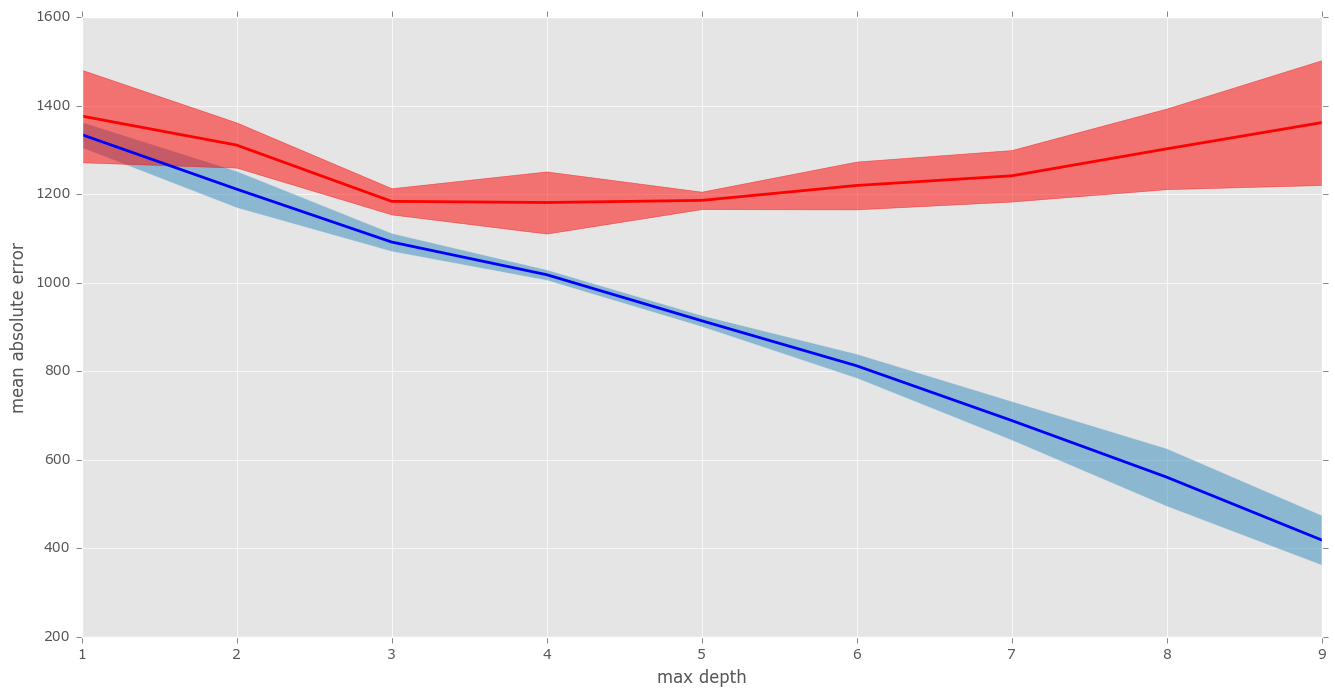

In [13]:
train_score_mean = -train_scores.mean(axis=1)
train_score_std = train_scores.std(axis=1)
valid_scores_mean = -valid_scores.mean(axis=1)
valid_scores_std = valid_scores.std(axis=1)

plt.fill_between(range(1,10), train_score_mean-train_score_std, train_score_mean+train_score_std, 
                 interpolate=True, alpha=0.5,)
plt.fill_between(range(1,10), valid_scores_mean-valid_scores_std, valid_scores_mean+valid_scores_std, color='r', 
                 interpolate=True, alpha=0.5)

plt.plot(range(1,10), train_score_mean, c='b', lw=2)
plt.plot(range(1,10), valid_scores_mean, c='r', lw=2)

plt.xlabel('max depth')
plt.ylabel('mean absolute error')

Мы видем, что на глубине дерева 3-5 ошибка на валидационном множестве минимальна, а затем начинает возрастать.

Ошибка же на обучающем множестве падает постоянно. 

При прочих равных, стоит выбрать глубину 3, так как ошибка минимальная и при этом сложность модели не такая высокая как при глубине 4-5.

## Подбор всех гиперпараметров

Почему случайный поиск лучше перебора:

<center><img src='https://cdn-images-1.medium.com/max/800/1*ZTlQm_WRcrNqL-nLnx6GJA.png'></center>

In [14]:
from scipy.stats import randint as randint
from scipy.stats import uniform
try:
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import RandomizedSearchCV
except ImportError:
    from sklearn.cross_validation import GridSearchCV
    from sklearn.cross_validation import RandomizedSearchCV


RND_SEED = 123

Теперь мы переключимся на случайный лес и запустим `RandomizedSearchCV` для подбора гиперпараметров.

In [15]:
# Определим пространство поиска

param_grid = {
    'n_estimators': randint(20, 100), # У нас не так много данных, этого достаточно
    'criterion': ['mse', 'mae'],
    'max_depth': randint(2, 8),
    'max_features': ['auto', 2],
    'min_samples_split': uniform(0, 0.1),
    'bootstrap': [True, False]}

# Некоторые параметры мы задали не простым перечислением значений, а 
# с помощью распределений.

# Будем делать 200 запусков поиска
# Можно пойти пить кофе =)
model = RandomForestRegressor(random_state=123)
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=200, n_jobs=4,
                                   cv=5, scoring='neg_mean_absolute_error', random_state=123)
# А дальше, просто .fit()
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=123,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=200, n_jobs=4,
          param_distributions={'bootstrap': [True, False], 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x10ec78e10>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x112254450>, 'criterion': ['mse', 'mae'], 'max_features': ['auto', 2], 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x112254050>},
          pre_dispatch='2*n_jobs', random_state=123, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          

In [18]:
print 'Лучшая оценка качества (по кросс-валидации): %f' % (- random_search.best_score_)

Лучшая оценка качества (по кросс-валидации): 1100.084957


In [19]:
print 'Лучше параметры:'
random_search.best_params_

Лучше параметры:


{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 7,
 'max_features': 2,
 'min_samples_split': 0.0066774443225004702,
 'n_estimators': 20}

In [20]:
# Можно составить DataFrame со значениями параметров и усредненной оценкой качества на них
try:
    grid = random_search.grid_scores_
except:
    grid = random_search.cv_results_

/Users/andrey.shestakov/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [21]:
df_grid = pd.DataFrame.from_dict([e.parameters for e in grid])
df_grid.loc[:, 'cv_mean_scores'] = [-e.mean_validation_score for e in grid]
df_grid.loc[:, 'cv_std_scores'] = [np.std(e.cv_validation_scores) for e in grid]
df_grid = df_grid.sort_values('cv_mean_scores', ascending=True)

In [22]:
df_grid.head()

,bootstrap,criterion,max_depth,max_features,min_samples_split,n_estimators,cv_mean_scores,cv_std_scores
49,True,mse,7,2,0.006677,20,1100.084957,83.519217
40,True,mse,7,auto,0.069631,45,1100.973281,72.009908
190,True,mse,6,auto,0.064479,88,1103.310346,74.991550
54,True,mse,5,auto,0.049620,27,1105.854929,79.910958
168,True,mse,5,auto,0.030637,38,1107.162950,74.381732


В данном случае, я бы выбрал 4 или 5 результат - сложность модели будет пониже, а в качестве уступает незначительно.

Но мы запомним эти, а возьмем все-таки первую модель.

Обратите внимание, что в топе нет ни одной модели с целевым критерием mae. Часто бывает, что функция оптимизации и функция метрики совпадают, но результаты могут быть хуже, чем если они отличаются.


In [23]:
best_model = random_search.best_estimator_

# Отдельный fit для лучшей модели не требуется - после RandomizedSearchCV с кросс-валидацией модель 
# обучается на всех данных из train set

## Важность признаков

In [24]:
best_model.feature_importances_

array([ 0.80954382,  0.06336607,  0.02854241,  0.03401003,  0.00781585,
        0.05672182])

In [25]:
importances = pd.Series(data=best_model.feature_importances_, 
                        index=df_test_preproc.columns[1:])\
                .sort_values()

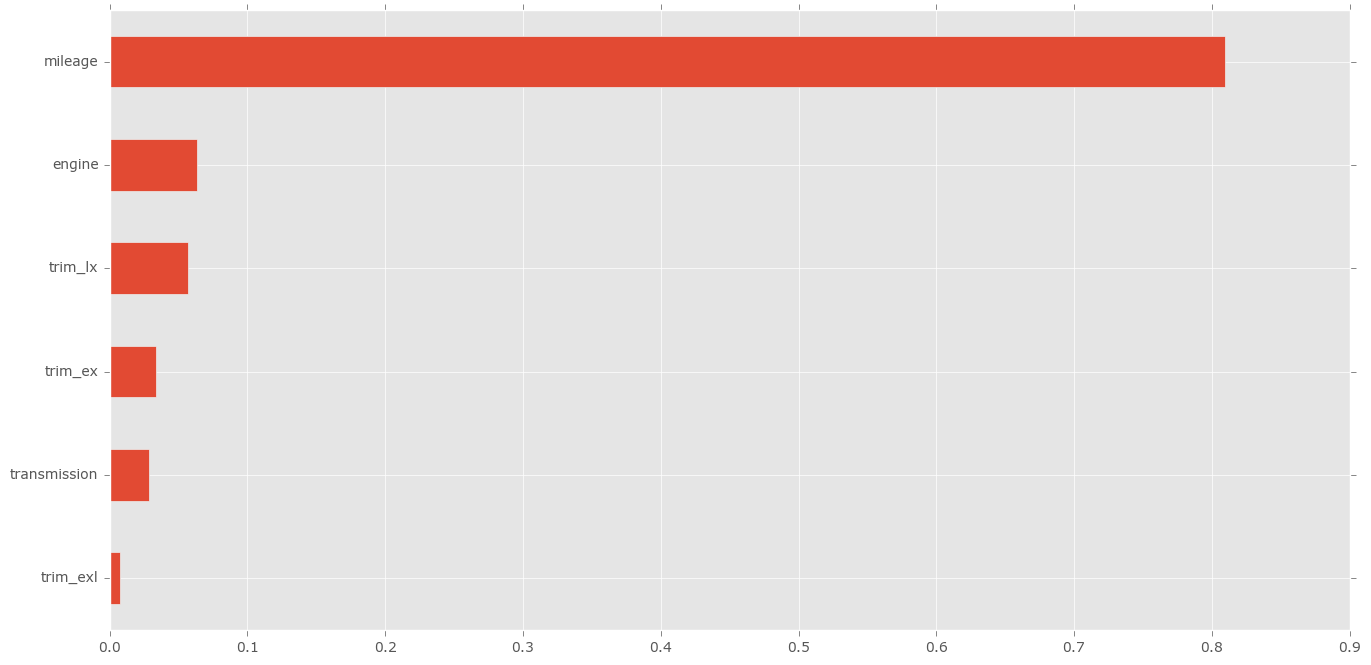

In [26]:
importances.plot(kind='barh')

Как и можно было ожидать - пробег оказывает наибольшее влияние на целевую переменную.

## Тестирование
Выберем лучший набор параметров, посмотрим, как алгоритм работает на тесте.

Также смухлюем и посмотрим другие наборы гиперпараметров

In [27]:
X_test, y_test = df_test_preproc.iloc[:, 1:].values, df_test_preproc.iloc[:, 0].values

In [28]:
y_hat = best_model.predict(X_test)

In [29]:
test_score = mean_absolute_error(y_hat, y_test)
test_score

1166.2882473140019

Проверим, как дела у 5й по качеству модели:

In [32]:
second_model = RandomForestRegressor(bootstrap=True, criterion='mse', n_estimators=38,
                                     max_depth=5, max_features='auto', 
                                     min_samples_split=0.030637, random_state=123)
second_model.fit(X_train, y_train)

y_hat = second_model.predict(X_test)

test_score = mean_absolute_error(y_hat, y_test)
test_score

1190.4686319607863

И все таки она оказалась похуже)

# Классификация

Рассмотрим построение дерева для одного из самых известных [наборов данных](https://www.kaggle.com/c/titanic/download/train.csv) о выживаемости после катастрофы, которая произошла с кораблем Титаник

Целевой признак - Survived

Сначала надо случайно разбить данные на обучающую и контрольную выборки.

In [118]:
from sklearn.ensemble import RandomForestClassifier
try:
    from sklearn.model_selection import train_test_split
except ImportError:
    from sklearn.cross_validation import train_test_split

In [119]:
# Your code here

df_titanic = pd.read_csv('titanic.csv', sep=',')

In [120]:
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [124]:
# В данных есть пропуски!
df_titanic.isnull().mean()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

In [125]:
df_train, df_test = train_test_split(df_titanic, test_size=0.2, random_state=123)

Повторим pipeline из предыдущей задачи

## Подготовка процедур для данных

In [126]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [127]:
enc = LabelEncoder().fit(df_train.Embarked)

In [132]:
def titanic_preproc(df_input, encoder=LabelEncoder(), fit_encoder=True):
    
    df = df_input.copy()
    
    # Создаем такой признак
    df.loc[:, 'has_cabin'] = df.loc[:, 'Cabin'].isnull().astype(int) 
    
    # Удаляем колонки
    cols2drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
    df = df.drop(cols2drop, axis=1)
    
    # Заменяем пропуски в Age
    df.loc[:, 'Age'] = df.loc[:, 'Age'].fillna(-9999)
    
    # Закодируем поле Sex
    df.loc[:, 'Sex'] = df.loc[:, 'Sex'].replace({'male': 0, 'female':1})
    
    # Pclass - можно рассматривать как категориальный признак
    # Для корректной работы one-hot его надо закодировать с 0
    df.loc[:, 'Pclass'] = df.loc[:, 'Pclass'] - 1 

    
    # Закодируем поле Embarked
    if encoder and fit_encoder:
        df.loc[:, 'Embarked'] = encoder.fit_transform(df.loc[:, 'Embarked'])
    else:
        df.loc[:, 'Embarked'] = encoder.transform(df.loc[:, 'Embarked'])
        
    return df, encoder

In [133]:
df_train_preproc, encoder = df_train.pipe(titanic_preproc)
df_test_preproc, _ = df_test.pipe(titanic_preproc, encoder=encoder, fit_encoder=False)

## Подбор всех гиперпараметров

По аналогии с предыдущей задачей, подберем гиперпараметры

Пока не тратим силы на оптимизацию модели

In [134]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_fscore_support

In [135]:
df_train_preproc.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,has_cabin
329,1,0,1,16.0,0,1,57.9792,1,0
749,0,2,0,31.0,0,0,7.7500,2,1
203,0,2,0,45.5,0,0,7.2250,1,1
421,0,2,0,21.0,0,0,7.7333,2,1
97,1,0,0,23.0,0,1,63.3583,1,0


In [136]:
X_train, y_train = df_train_preproc.iloc[:, 1:].values, df_train_preproc.iloc[:, 0].values

In [137]:
# Поставим целевую метрику roc-auc, а все остальное просто поизучаем

# Будем делать 200 запусков поиска
# Можно пойти пить кофе =)
model = Pipeline([('onehot', OneHotEncoder(categorical_features=[0, 6]) ), # Pclass и Embarked - категориальные
                  ('rf', RandomForestClassifier(random_state=123))])

# У нас композитная модель - сначала идет onehot категориальных признаков, потом случайный лес.
# Чтобы дать понять, что мы должны перебирать параметры случайнго леса в param_grid
# надо добавить название соответствующего шага - в нашем случае "rf"

param_grid = {
    'rf__n_estimators': randint(20, 100), # У нас не так много данных, этого достаточно
    'rf__max_depth': randint(2, 8),
    'rf__max_features': ['log2', 'sqrt', 2],
    'rf__min_samples_split': uniform(0, 0.1)}

random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=200, n_jobs=4,
               cv=5, scoring='roc_auc', random_state=123)

In [138]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(steps=[('onehot', OneHotEncoder(categorical_features=[0, 6], dtype=<type 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes...timators=10, n_jobs=1, oob_score=False, random_state=123,
            verbose=0, warm_start=False))]),
          fit_params={}, iid=True, n_iter=200, n_jobs=4,
          param_distributions={'rf__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x115ae0950>, 'rf__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x115ae08d0>, 'rf__max_features': ['log2', 'sqrt', 2], 'rf__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x115ae0450>},
          pre_dispatch='2*n_jobs', random_state=123, refit=True,
          return_train_score=True, scoring='roc_auc', v

In [139]:
print 'Лучшая оценка качества (по кросс-валидации): %f' % (random_search.best_score_)

Лучшая оценка качества (по кросс-валидации): 0.856343


In [140]:
print 'Лучше параметры:'
random_search.best_params_

Лучше параметры:


{'rf__max_depth': 5,
 'rf__max_features': 'sqrt',
 'rf__min_samples_split': 0.018033628310429272,
 'rf__n_estimators': 74}

In [146]:
try:
    grid = random_search.grid_scores_
except:
    grid = random_search.cv_results_
    
df_grid = pd.DataFrame.from_dict([e.parameters for e in grid])
df_grid.loc[:, 'cv_mean_scores'] = [-e.mean_validation_score for e in grid]
df_grid.loc[:, 'cv_std_scores'] = [np.std(e.cv_validation_scores) for e in grid]
df_grid = df_grid.sort_values('cv_mean_scores', ascending=True)

/Users/andrey.shestakov/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [147]:
df_grid.head()

,rf__max_depth,rf__max_features,rf__min_samples_split,rf__n_estimators,cv_mean_scores,cv_std_scores
19,5,sqrt,0.018034,74,-0.856343,0.024515
105,5,log2,0.024503,54,-0.855294,0.023125
23,5,log2,0.010854,69,-0.855173,0.021970
98,5,sqrt,0.052184,92,-0.854754,0.024584
106,6,2,0.009219,60,-0.854193,0.029477


In [148]:
final_model = random_search.best_estimator_

In [164]:
# Тут немнго посложнее - 
# Во-первых, мы делали one-hot и поэтому надо понять где какой признак
# Во-вторых, надо в Pipeline добраться до randomforest

enc = final_model.steps[0][1]
# сложно написал.. но мы получили категориальные признаки
cat_features = ['%s_%d' % (fname, j-enc.feature_indices_[i]) for i, fname in enumerate(df_train_preproc.columns[[1,7]]) for j in range(enc.feature_indices_[i], enc.feature_indices_[i+1])]
cont_features = df_train_preproc.columns[[2,3,4,5,6,8]].tolist()

all_features = cat_features + cont_features

In [165]:
cont_features

['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'has_cabin']

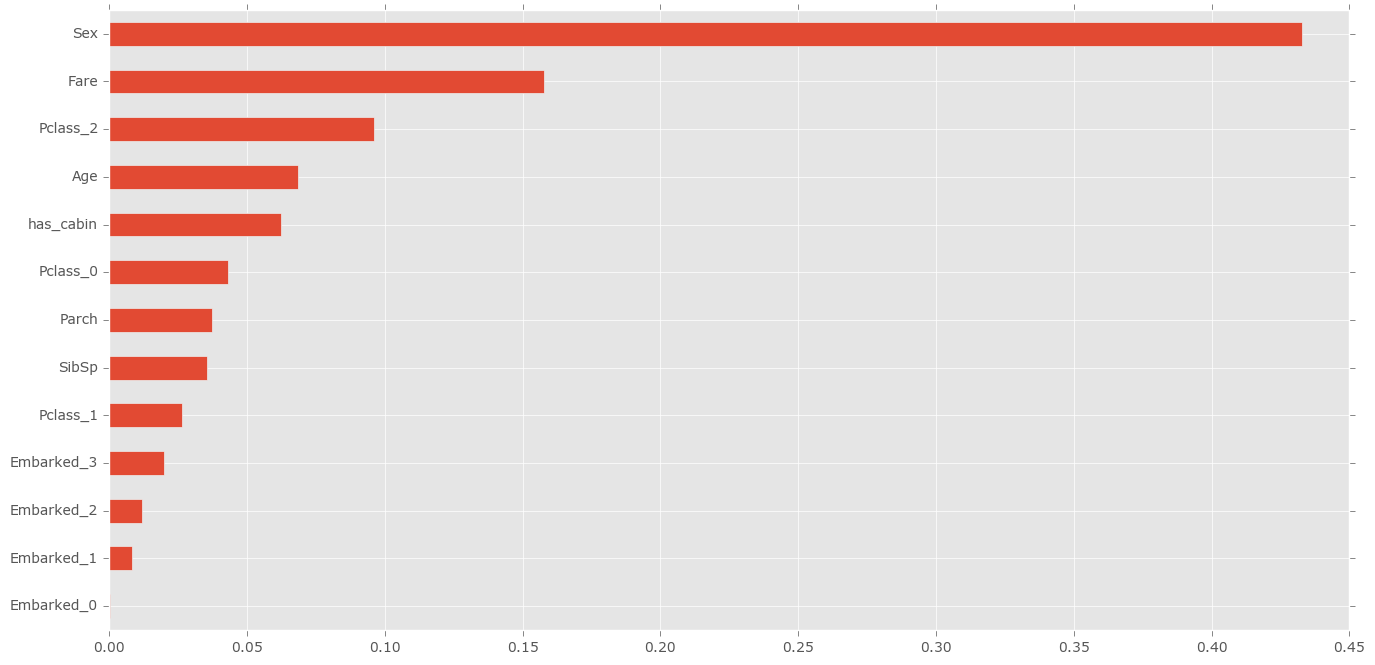

In [166]:

importances = pd.Series(data=final_model.steps[1][1].feature_importances_, 
                        index=all_features)\
                .sort_values()
importances.plot(kind='barh')

Ну да, спаслись в основном женщины (это из истории, а не из картинки). Так же на результат влиает Fare.

В этом и недостаток "важности признаков" в деревянных методов - не видно тендеции влияния.


## Построим и посчитаем разные метрики качества

In [167]:
X_test, y_test = df_test_preproc.iloc[:, 1:].values, df_test_preproc.iloc[:, 0].values

In [168]:
# Возвращает массив с вероятностями каждого класса
y_hat_train_proba = final_model.predict_proba(X_train)[:, 1] 

# Возвращает предсказание на основе большинства
y_hat_train = final_model.predict(X_train)

y_hat_test_proba = final_model.predict_proba(X_test)[:, 1] 
y_hat_test = final_model.predict(X_test)

## ROC-Curve + PR-Curve

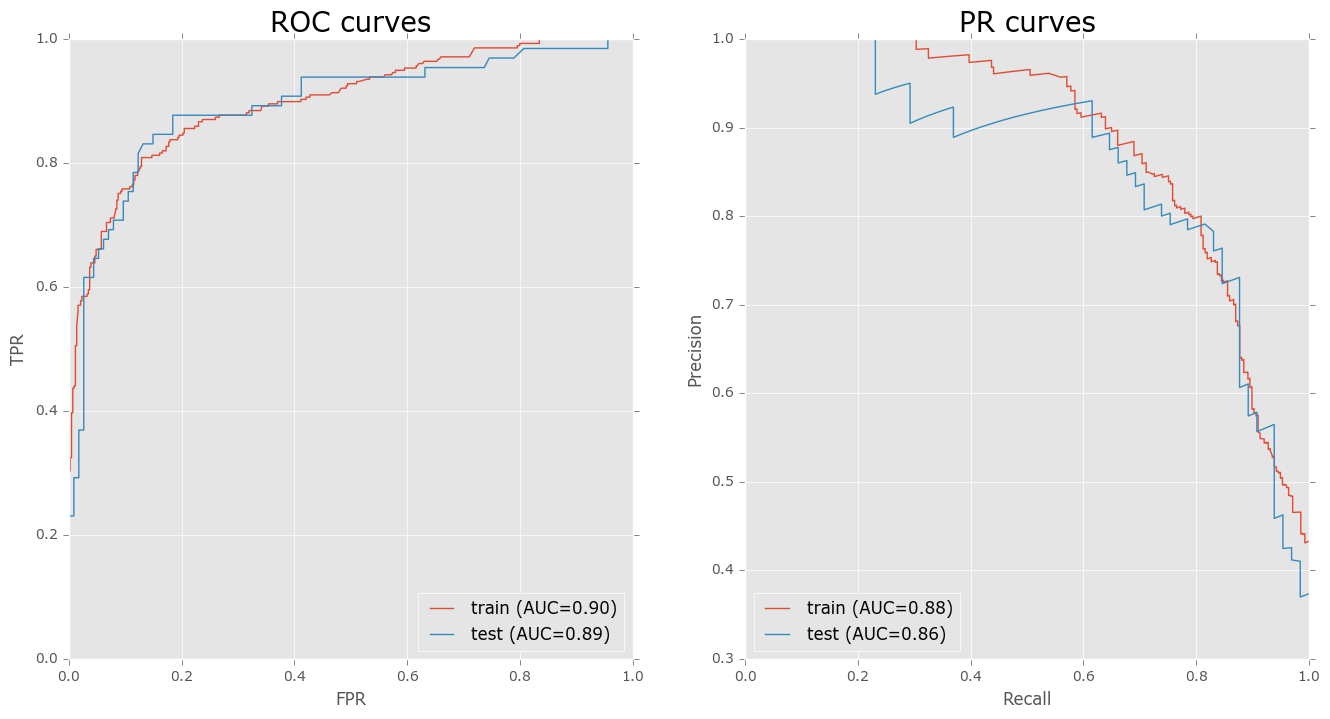

In [169]:
fig, ax = plt.subplots(1, 2)

# ROC

fpr, tpr, _ = roc_curve(y_train, y_hat_train_proba)
auc_score = roc_auc_score(y_train, y_hat_train_proba)

ax[0].plot(fpr, tpr, label='train (AUC=%.2f)' % auc_score)

fpr, tpr, _ = roc_curve(y_test, y_hat_test_proba)
auc_score = roc_auc_score(y_test, y_hat_test_proba)

ax[0].plot(fpr, tpr, label='test (AUC=%.2f)' % auc_score)

ax[0].set_xlabel('FPR')
ax[0].set_ylabel('TPR')
ax[0].set_title('ROC curves', fontsize=20)
ax[0].legend(loc=4)

# PR
pr, rec, _ = precision_recall_curve(y_train, y_hat_train_proba)
auc_score = auc(rec, pr)

ax[1].plot(rec, pr, label='train (AUC=%.2f)' % auc_score)

pr, rec, _ = precision_recall_curve(y_test, y_hat_test_proba)
auc_score = auc(rec, pr)

ax[1].plot(rec, pr, label='test (AUC=%.2f)' % auc_score)


ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('PR curves', fontsize=20)
ax[1].legend(loc=3)

In [175]:
print 'Confusion matrix 4 train'
print confusion_matrix(y_train, y_hat_train, labels=[1,0])
print '='*10 + '\nConfusion matrix 4 test'
print confusion_matrix(y_test, y_hat_test, labels=[1,0])

Confusion matrix 4 train
[[191  86]
 [ 28 407]]
Confusion matrix 4 test
[[ 46  19]
 [ 11 103]]


In [176]:
print 'Report 4 train'
print classification_report(y_train, y_hat_train)
print '='*10 + '\nReport 4 test'
print classification_report(y_test, y_hat_test)

Report 4 train
             precision    recall  f1-score   support

          0       0.83      0.94      0.88       435
          1       0.87      0.69      0.77       277

avg / total       0.84      0.84      0.84       712

Report 4 test
             precision    recall  f1-score   support

          0       0.84      0.90      0.87       114
          1       0.81      0.71      0.75        65

avg / total       0.83      0.83      0.83       179

